In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# yellow_taxi = pd.read_parquet('../Data/yellow_taxi_clean.parquet')  # Ejecutar solo cuando sea necesario cargar los datos limpios

Función `range_data` extrae un rango de archivos Parquet y los carga como DataFrames. Los parametros solicitados son:
- `url_trim` Porción de la url que se mantiene invariable
- `start_m` Mes del intervalo inferior
- `start_y` Año del intervalo inferior
- `end_m` Mes del intervalo superior
- `end_y` Año del intervalo superior

In [2]:
def downloaddf(url_trim:str,month:int,year:int):
    if len (str(int(month)))==1:
        month='0'+str(month)
    return  pd.read_parquet(url_trim+str(year)+'-'+str(month)+'.parquet')

def range_data(url_trim:str,start_m:int, start_y:int, end_m:int, end_y:int):
    if end_y - start_y < 0:
        return 'Error:  End Year is smaller than Start Year'
    elif end_y ==  start_y and end_m < start_m:
        return 'Error:  End Month is smaller than or equal to Start Month'
    elif start_m > 12 or end_m > 12:
        return 'Error: End Month or  Start Month is larger than 12'
    elif end_y ==  start_y and end_m == start_m:
        return downloaddf(url_trim,start_m,start_y)
    elif end_y == start_y:
        df1 =downloaddf(url_trim,start_m,start_y)
        for i in range(start_m + 1,end_m + 1):
            df2 =downloaddf(url_trim,i,start_y)
            df1 = pd.concat([df1,df2],ignore_index=True)
            del df2
        return df1
    elif  end_y > start_y:
        df1 =downloaddf(url_trim,start_m,start_y)
        for j in range(start_y ,end_y + 1):
            for k in range(start_m + 1,13):
                if  j==end_y and  k > end_m :break
                df2 =downloaddf(url_trim,k,j)
                df1 = pd.concat([df1,df2],ignore_index=True)
                del df2
            start_m  = 1
        return df1

## Yellow Taxi

Carga del conjunto de datos para `Yellow Taxi` comprendidos entre Diciembre del 2023 a Febrero del 2024 (Últimos tres meses)

In [3]:
url_trim = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_20'
yellow_taxi = range_data(url_trim,12,23,2,24)

Descarga alternativa del datos

In [4]:
df1 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-12.parquet')
df2 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')
df3 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet')
yellow_taxi = pd.concat([df1,df2,df3],ignore_index=True)

Identificadores de zona de NYC

In [5]:
url_zonas = 'https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv'
zonas = pd.read_csv(url_zonas)

## Descripción general de los datos

El conjunto de datos utilizado para el análisis exploratorio de datos (EDA) de los taxis amarillos abarca los últimos **3 meses disponibles** a la fecha de realización (de **diciembre de 2023 a febrero de 2024**). Este intervalo temporal contiene poco más de **9 millones de registros** de los cuales se encontraron cerca de **506 mil registros nulos** lo cual **representa el 5.41% de los datos** analizados.

In [6]:
yellow_taxi.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9348717 entries, 0 to 9348716
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               9348717 non-null  int32         
 1   tpep_pickup_datetime   9348717 non-null  datetime64[us]
 2   tpep_dropoff_datetime  9348717 non-null  datetime64[us]
 3   passenger_count        8842942 non-null  float64       
 4   trip_distance          9348717 non-null  float64       
 5   RatecodeID             8842942 non-null  float64       
 6   store_and_fwd_flag     8842942 non-null  object        
 7   PULocationID           9348717 non-null  int32         
 8   DOLocationID           9348717 non-null  int32         
 9   payment_type           9348717 non-null  int64         
 10  fare_amount            9348717 non-null  float64       
 11  extra                  9348717 non-null  float64       
 12  mta_tax                93487

In [7]:
nulos = yellow_taxi[yellow_taxi['passenger_count'].isna() == True]['VendorID'].count()
yellow_taxi[yellow_taxi['passenger_count'].isna() == True].count()

VendorID                 505775
tpep_pickup_datetime     505775
tpep_dropoff_datetime    505775
passenger_count               0
trip_distance            505775
RatecodeID                    0
store_and_fwd_flag            0
PULocationID             505775
DOLocationID             505775
payment_type             505775
fare_amount              505775
extra                    505775
mta_tax                  505775
tip_amount               505775
tolls_amount             505775
improvement_surcharge    505775
total_amount             505775
congestion_surcharge          0
Airport_fee                   0
dtype: int64

In [8]:
print(f"Se tienen un total de {yellow_taxi['VendorID'].count()} de los cuales {nulos} son registros nulos, lo cual representa un {round(nulos * 100/ yellow_taxi['VendorID'].count(),2)}% de los datos")

Se tienen un total de 9348717 de los cuales 505775 son registros nulos, lo cual representa un 5.41% de los datos


Despues de eliminar los registros nulos nos **quedan alrededor de 8.8 millones** de registros

In [9]:
yellow_taxi = yellow_taxi.dropna()
print(f"Quedan {yellow_taxi['VendorID'].count()} registros")

Quedan 8842942 registros


En esta primera inspección, se pueden visualizar registros que contienen valores atípicos en las siguientes variables:

- `tpep_pickup_datetime`
- `tpep_dropoff_datetime`
- `trip_distance`
- `extra`
- `mta_tax`
- `tip_amount`
- `tolls_amount`
- `total_amount`

Estos valores atípicos pueden afectar el análisis y deben ser considerados al procesar los datos. Es importante investigar más a fondo para comprender la naturaleza de estos registros y decidir cómo manejarlos en el contexto del análisis exploratorio de datos.

In [10]:
yellow_taxi.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,8.842942e+06,8842942,8842942,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06,8.842942e+06
mean,1.757060e+00,2024-01-14 14:38:42.655637,2024-01-14 14:55:20.555183,1.359922e+00,3.337742e+00,1.984252e+00,1.658360e+02,1.649052e+02,1.222013e+00,1.856954e+01,1.535385e+00,4.824741e-01,3.501427e+00,5.482924e-01,9.744790e-01,2.744127e+01,2.264431e+00,1.358217e-01
min,1.000000e+00,2002-12-31 22:16:54,2002-12-31 23:05:41,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.087300e+03,-7.500000e+00,-5.000000e-01,-1.400000e+02,-8.000000e+01,-1.000000e+00,-1.094050e+03,-2.500000e+00,-1.750000e+00
25%,2.000000e+00,2023-12-19 21:42:44.250000,2023-12-19 21:56:46,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.548000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2024-01-14 23:01:15.500000,2024-01-14 23:14:53.500000,1.000000e+00,1.680000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.800000e+00,0.000000e+00,1.000000e+00,2.050000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2024-02-07 12:28:45,2024-02-07 12:47:42.750000,1.000000e+00,3.110000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.120000e+01,2.500000e+00,5.000000e-01,4.340000e+00,0.000000e+00,1.000000e+00,2.970000e+01,2.500000e+00,0.000000e+00
max,2.000000e+00,2024-03-01 00:01:37,2024-03-01 23:24:42,9.000000e+00,1.617261e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.000000e+03,5.168000e+01,5.750000e+00,4.174000e+03,1.613800e+02,1.000000e+00,5.000000e+03,2.500000e+00,1.750000e+00
std,4.288594e-01,NaN,NaN,8.679405e-01,8.485820e+01,9.396248e+00,6.350249e+01,6.932214e+01,5.353514e-01,1.884785e+01,1.820353e+00,1.207479e-01,4.231450e+00,2.168942e+00,2.236907e-01,2.356329e+01,8.145729e-01,4.789160e-01


Se han identificado 10 registros con fechas de inicio de viaje (`tpep_pickup_datetime`) que están fuera del rango de tiempo establecido. Por lo tanto, se eliminarán estos datos por encontrarse fuera del periodo temporal definido para el análisis.

In [11]:
yellow_taxi[yellow_taxi['tpep_pickup_datetime'].dt.year < 2023]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
1128759,2,2002-12-31 22:16:54,2003-01-01 15:02:08,1.0,3.25,1.0,N,132,10,1,14.9,1.75,0.5,3.63,0.00,1.0,21.78,0.0,0.00
2531205,2,2002-12-31 23:03:18,2003-01-01 21:09:44,1.0,28.19,2.0,N,132,13,1,70.0,0.00,0.5,16.54,6.94,1.0,99.23,2.5,1.75
2601397,2,2009-01-01 00:02:41,2009-01-01 17:43:28,1.0,1.37,1.0,N,230,142,1,10.7,0.00,0.5,1.47,0.00,1.0,16.17,2.5,0.00
3387482,2,2009-01-01 23:58:40,2009-01-02 00:01:40,1.0,0.46,1.0,N,137,264,2,4.4,3.50,0.5,0.00,0.00,1.0,9.40,0.0,0.00
3429686,2,2002-12-31 22:59:39,2002-12-31 23:05:41,1.0,0.63,1.0,N,170,170,3,-6.5,0.00,-0.5,0.00,0.00,-1.0,-10.50,-2.5,0.00
3429687,2,2002-12-31 22:59:39,2002-12-31 23:05:41,1.0,0.63,1.0,N,170,170,3,6.5,0.00,0.5,0.00,0.00,1.0,10.50,2.5,0.00
4606736,2,2009-01-01 23:30:39,2009-01-02 00:01:39,1.0,10.99,1.0,N,237,264,2,45.0,3.50,0.5,0.00,0.00,1.0,50.00,0.0,0.00
5934623,2,2009-01-01 00:24:09,2009-01-01 01:13:00,2.0,10.88,1.0,N,138,264,2,50.6,9.25,0.5,0.00,6.94,1.0,68.29,0.0,0.00
6522474,2,2008-12-31 22:52:49,2008-12-31 23:04:09,1.0,1.62,1.0,N,141,211,1,11.4,2.50,0.5,2.00,0.00,1.0,19.90,2.5,0.00
7240044,2,2009-01-01 00:02:13,2009-01-01 00:48:28,1.0,0.57,1.0,N,79,148,1,9.3,1.00,0.5,2.86,0.00,1.0,17.16,2.5,0.00


Eliminando registros fuera del rango temporal

In [12]:
yellow_taxi = yellow_taxi[yellow_taxi['tpep_pickup_datetime'].dt.year >= 2023]

El rango temporal es de 92 días (Aproximadamente 3 meses)

In [13]:
print(yellow_taxi['tpep_pickup_datetime'].dt.date.max() - yellow_taxi['tpep_pickup_datetime'].dt.date.min())

92 days, 0:00:00


### Variables
#### Variables cualitativas

1. `VendorID`. Identificador del proveedor del Taxicab Technology Service Provider (TPEP), el cual puede presentar solo dos ID´s:
- 1= Creative Mobile Technologies, LLC
- 2= VeriFone Inc.

2. `RateCodeID`. Identificador de tarifa vigente al finalizar el viaje. Puede tomar los siguientes valores:
- 1=Tarifa estándar
- 2=JFK
- 3=Newark
- 4=Nassau o Westchester
- 5=Tarifa negociada
- 6=Tarifa grupal

3. `Store_and_fwd_flag`. Esta variable indica si el registro se almaceno en el vehiculo para posteriormente enviarse al servidor. Debido a conectividad. Puede tomar los Valores (Y= Almacenado y posterior envio, N= No almacenado, se envio al servidor)
4. `PULocationID`. Zona dónde se inicio el Taximetro, las zonas se segmentan con valores enteros que van del 1 al 265, (consulte el DataFrame `zonas`)

5. `DOLocationID`. Zona dónde se finalizo el Taximetro (Consulte DataFrame Zonas)

6. `payment_type`. Tipo de pago, los valores pueden ser:
- 1= Tarjeta de crédito
- 2= Efectivo
- 3= Sin cargo
- 4= Disputa
- 5= Desconocido
- 6= Viaje anulado

El proveedor de TPEP con mayor presencia (`VendorID`) es VeriFone Inc. ya que el 75% de los registros provienen de ellos

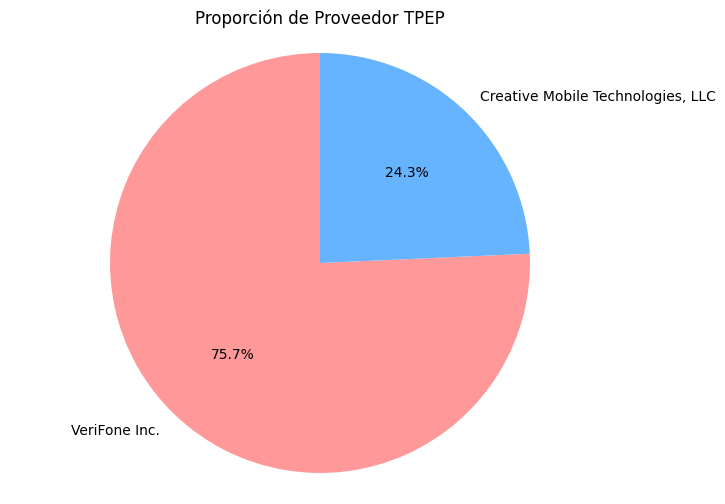

In [14]:
# Datos
vendor = {1:'Creative Mobile Technologies, LLC', 2:'VeriFone Inc.'}
vendor_counts = list(yellow_taxi['VendorID'].value_counts())
labels = ['VeriFone Inc.', 'Creative Mobile Technologies, LLC']
colors = ['#FF9999', '#66B3FF']

# Crear la gráfica circular
plt.figure(figsize=(8, 6))
plt.pie(vendor_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Proporción de Proveedor TPEP')
plt.axis('equal')  # Aspecto igual para que sea un círculo

# Mostrar la gráfica
plt.show()


La tarifa identificada con el número `99`, que no figura en la documentación oficial, resalta por ser la **tercera más frecuente** en el uso durante los últimos tres meses. Es esencial prestar atención a esta tarifa debido a su inesperada alta incidencia.

In [15]:
yellow_taxi['RatecodeID'].value_counts()

RatecodeID
1.0     8345859
2.0      307115
99.0      82021
5.0       61686
3.0       27015
4.0       19222
6.0          14
Name: count, dtype: int64

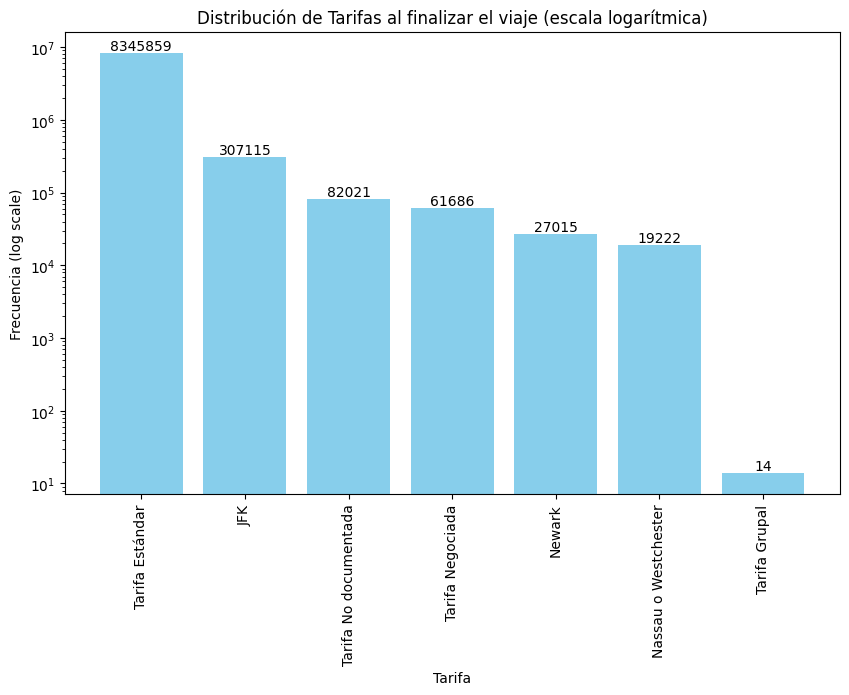

In [16]:
ratecode_counts = yellow_taxi['RatecodeID'].value_counts()
RCID = {1:'Tarifa Estándar',2:'JFK',3:'Newark',4:'Nassau o Westchester',5:'Tarifa Negociada',6:'Tarifa Grupal',99:'Tarifa No documentada'}
# Ahora, crearemos una lista de etiquetas basadas en el diccionario RCID para las barras del histograma.
labels = [RCID[id] if id in RCID else 'Other' for id in ratecode_counts.index]

# Crear el histograma con escala logarítmica en el eje y
plt.figure(figsize=(10, 6))
plt.bar(labels, ratecode_counts.values, color='skyblue')
plt.yscale('log')  # Escala logarítmica en el eje y

# Añadir título y etiquetas
plt.title('Distribución de Tarifas al finalizar el viaje (escala logarítmica)')
plt.xlabel('Tarifa')
plt.ylabel('Frecuencia (log scale)')
plt.xticks(rotation = 90)

# Mostrar las etiquetas en las barras
for i, value in enumerate(ratecode_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Mostrar el histograma
plt.show()


La información indica que la gran mayoría de los datos de los viajes en taxi se transmiten justo al finalizar el trayecto, lo cual sugiere que hay una capacidad para realizar un seguimiento en tiempo real. Sin embargo, un pequeño porcentaje, específicamente el **0.4%**, se guarda para enviar más tarde, lo que podría implicar ligeras demoras en la recepción de esos datos. Este patrón de envío de datos refuerza la viabilidad de implementar un sistema de monitoreo en tiempo real para la mayoría de los servicios de taxi.

In [17]:
porcentaje = list(yellow_taxi['store_and_fwd_flag'].value_counts())[1]/(list(yellow_taxi['store_and_fwd_flag'].value_counts())[0]+list(yellow_taxi['store_and_fwd_flag'].value_counts())[1])
print(f"La proporcion de registros almacenados y enviados posteriormente es del {round(porcentaje*100,2)}%")

La proporcion de registros almacenados y enviados posteriormente es del 0.4%


Es interesante observar que la mayoría de los viajes en taxi comienzan en **Manhattan**, **Queens** y **Brooklyn**, lo que no es sorprendente dado que son áreas muy transitadas en la ciudad de Nueva York. Sin embargo, también es relevante notar que existe un volumen significativo de viajes en los que **se desconoce el origen** del viaje. Esto podría deberse a diversas razones, como errores en la recopilación de datos o la falta de información precisa en algunos registros.

In [18]:
# Creando DF que relaciona Zona, Borough, Zona de Servicio y el número de servicios.
ZI = {'LocationID':list(yellow_taxi['PULocationID'].value_counts().index),
      'Número de servicios':list(yellow_taxi['PULocationID'].value_counts())}
ZonaInicio = pd.DataFrame(ZI)
# ZonaInicio.merge(zonas, by)
# zonas['LocationID']
ZonaInicio = pd.merge(ZonaInicio,zonas,on='LocationID', how='inner')

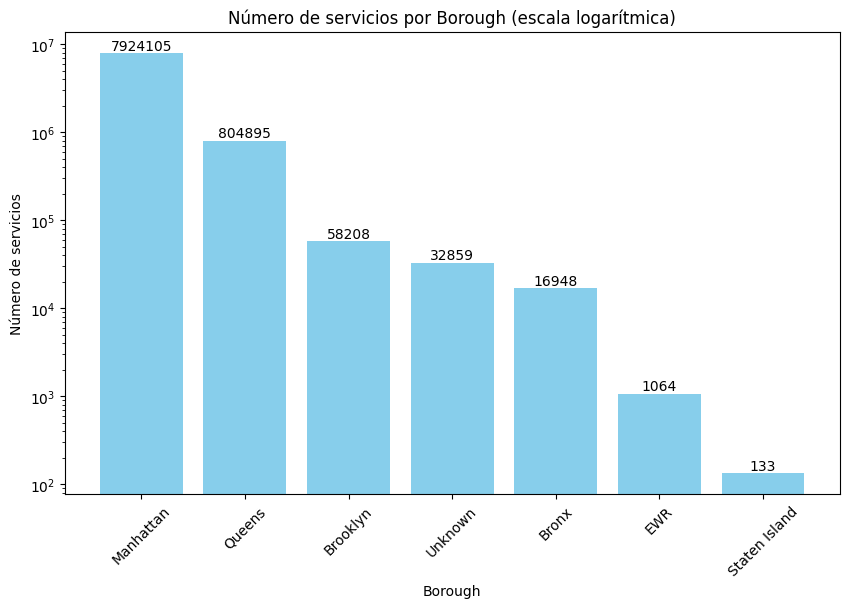

In [19]:
borough_services = ZonaInicio.groupby('Borough')['Número de servicios'].sum().reset_index()

# Ordenar los datos para una mejor visualización
borough_services_sorted = borough_services.sort_values('Número de servicios', ascending=False)

# Crear el histograma con escala logarítmica en el eje y
plt.figure(figsize=(10, 6))
plt.bar(borough_services_sorted['Borough'], borough_services_sorted['Número de servicios'], color='skyblue')
plt.yscale('log')  # Escala logarítmica en el eje y

# Mostrar las etiquetas en las barras
for i, value in enumerate(borough_services_sorted['Número de servicios'].values):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Añadir título y etiquetas
plt.title('Número de servicios por Borough (escala logarítmica)')
plt.xlabel('Borough')
plt.ylabel('Número de servicios')

# Girar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar el histograma
plt.show()


Es notable que los **Yellow Taxis** inician la mayoría de sus servicios en la **Yellow Zone**, con aproximadamente **7.7 millones de viajes**, lo que indica una alta concentración de actividad en esta área. Por otro lado, los viajes que comienzan en los **aeropuertos** representan alrededor de **700,000**, y en la **Boro Zone**, solo aproximadamente **325,000**. Esto muestra una distribución desigual de los servicios de taxi, con una clara preferencia por la Yellow Zone, probablemente debido a la alta demanda y la facilidad de acceso a pasajeros en esa área. La menor cantidad de servicios que se originan en los aeropuertos y en la Boro Zone podría reflejar una menor demanda y la presencia de otras opciones de transporte en esas zonas.

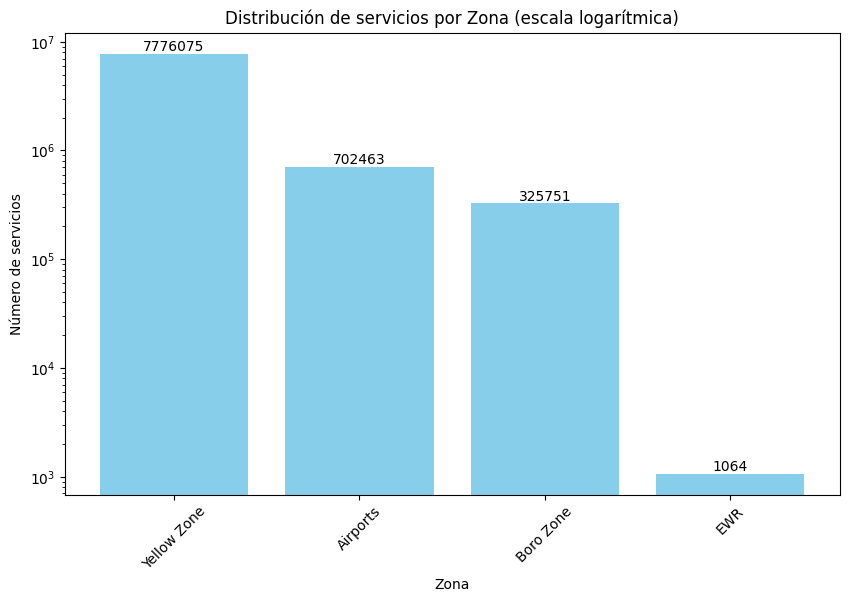

In [20]:
Zona_servicio = ZonaInicio.groupby('service_zone')['Número de servicios'].sum().reset_index()

# Ordenar los datos para una mejor visualización
Zona_servicio_sorted = Zona_servicio.sort_values('Número de servicios', ascending=False)

# Crear el histograma con escala logarítmica en el eje y
plt.figure(figsize=(10, 6))
plt.bar(Zona_servicio_sorted['service_zone'], Zona_servicio_sorted['Número de servicios'], color='skyblue')
plt.yscale('log')  # Escala logarítmica en el eje y

# Mostrar las etiquetas en las barras
for i, value in enumerate(Zona_servicio_sorted['Número de servicios'].values):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Añadir título y etiquetas
plt.title('Distribución de servicios por Zona (escala logarítmica)')
plt.xlabel('Zona')
plt.ylabel('Número de servicios')

# Girar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar el histograma
plt.show()


La siguiente imagen muestra las 10 zonas con más viajes 

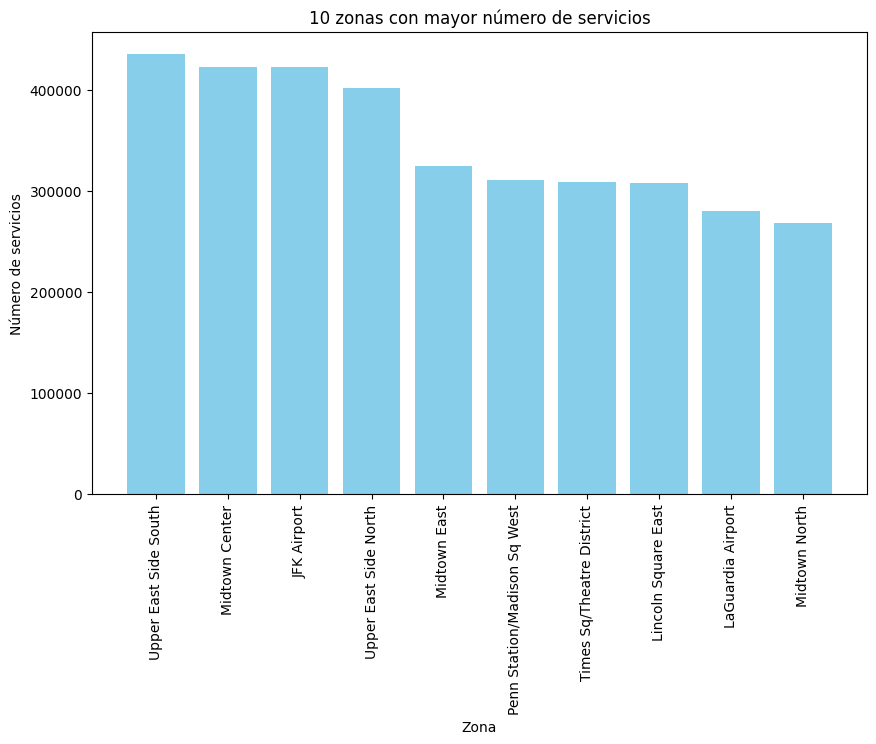

In [21]:
# Cantidad de zonas a mostrar en el gráfico
n = 10
zona_sorted = ZonaInicio[['Zone', 'Número de servicios']].sort_values(by='Número de servicios', ascending=False).head(n)

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.bar(zona_sorted['Zone'].astype(str), zona_sorted['Número de servicios'], color='skyblue')  # Convertir a str

# Añadir título y etiquetas
plt.title(f'{n} zonas con mayor número de servicios')
plt.xlabel('Zona')
plt.ylabel('Número de servicios')

# Girar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=90)

# Mostrar el histograma
plt.show()


Para identificar las rutas más transitadas, se crea la variable `trip_outside_zone`. Esta variable es **TRUE** cuando el destino del viaje es distinto a su punto de partida.

In [22]:
yellow_taxi['trip_outside_zone'] = yellow_taxi['PULocationID'] != yellow_taxi['DOLocationID']

Creando variable `route` la cual define la zona del punto de partida y destino de cada viaje

In [ ]:
# Esta celda demora bastante en ejecutare :( Si es localmente :`(, ya que filtra n veces el DF zonas y devuelve la zona al aplicarse el apply 
# en el df yellow taxi.
def idzone2zone(id:int):
    try:
        filtro = zonas[zonas['LocationID'] == id].reset_index()
        return filtro['Zone'].loc[0]
    except:
        return np.nan

yellow_taxi['route'] = yellow_taxi['PULocationID'].apply(idzone2zone) +' -- '+ yellow_taxi['DOLocationID'].apply(idzone2zone)

In [ ]:
yellow_taxi.sample()

El gráfico titulado "20 rutas más solicitadas en NYC" muestra las rutas de taxis amarillos en Nueva York que tienen la mayor demanda.

- **Ruta Superior**: La ruta más popular es de **Upper East Side South a Upper East Side North**, lo que indica una alta demanda de viajes dentro de esta área.
- **Rutas Comunes**: Varias rutas conectan **Upper East Side** con **Midtown** y **Lincoln Square**, lo que refleja patrones comunes de desplazamiento.
- **Demanda de Servicios**: Las barras representan el número de servicios, con la ruta más solicitada alcanzando hasta **40,000** servicios.
- **Planificación Urbana**: Este análisis de datos es útil para la **planificación del tráfico** y la **gestión urbana**, ayudando a entender los patrones de movilidad y optimizar los servicios de transporte.

In [ ]:
# Cantidad de rutas a mostrar en el gráfico
n = 20
rutas = yellow_taxi.groupby('route')['route'].count().sort_values(ascending=False).head(n)

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.bar(list(rutas.index), list(rutas), color='skyblue')

# Añadir título y etiquetas
plt.title(f'{n} rutas más solicitadas en NYC')
plt.xlabel('Ruta')
plt.ylabel('Número de servicios')

# Girar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=90)

# Mostrar el histograma
plt.show()

El gráfico titulado "Métodos de Pago en Yellow Taxis" muestra las preferencias de pago de los clientes que utilizan taxis:

- **Predominio de Tarjetas**: La **tarjeta de crédito** es el método de pago más utilizado, con una frecuencia de **7.2 millones**.
- **Efectivo Sigue Vigente**: El pago en **efectivo** es el segundo más común, alrededor de los **1.4 millones** transacciones.
- **Menos Disputas y Sin Cargo**: Las categorías de **disputa** y **sin cargo** tienen frecuencias mucho menores, con **~150 mil** y **60 mil** respectivamente.
- **Tendencias de Pago**: Este gráfico muestra una tendencia de pago con tarjeta de crédito.

In [ ]:
payment_counts = yellow_taxi['payment_type'].value_counts()
payment_method = {1:'Tarjeta de crédito',2:'Efectivo',3:'Sin cargo',4:'Disputa',5:'Desconocido',6:'Viaje anulado'}

# Crear una lista de nombres de métodos de pago basada en el diccionario 'payment_method'
payment_names = [payment_method[payment_id] if payment_id in payment_method else 'Desconocido'
                 for payment_id in payment_counts.index]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(payment_names, payment_counts.values, color='skyblue')

# Mostrar las etiquetas en las barras
for i, value in enumerate(payment_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Añadir título y etiquetas a los ejes
plt.title('Métodos de Pago en Yellow Taxis')
plt.xlabel('Método de Pago')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()


#### Variables cualitativas

1. `tpep_pickup_datetime`. Fecha y hora en la que se activo el taximetro
2. `tpep_dropoff_datetime`. Fecha y hora en la que se termino el servico
3. `passenger_count`. Número de pasajeros. (Valor ingresado por el controlador). Variable discreta que van desde 1 a 9 pasajeros
4. `trip_distance`. Distancia registrada por el taxímetro. Variable continua medida en millas
5. `fare_amount`. Tarifa de tiempo y distancia calculada por el taxímetro
6. `extra`. Extras y recargos, se incluyen unicamente cargos por horas pico y noche de $0.50 y $1 respectivamente
7. `mta_tax`. Impuesto MTA de $0.50 que se activa automáticamente en función de la tarifa medida en uso.
8. `tip_amount`. Propina, unicamente se incluyen cuando el método de pago es con tarjeta de crédito. Propinas en efectivo no incluidas
9. `tolls_amount`. Importe total de todos los peajes pagados en viaje.
10. `improvement_surcharge`. Cargo por mejora de $0.30
11. `total_amount`. Importe total cobrado. No se incluyen propinas en efectivo.
12. `congestion_surcharge`. Recargo total por congestión del Estado de Nueva York.
13. `Airport_fee`. $1.25 para recoger solo en los aeropuertos LaGuardia y John F. Kennedy

El gráfico muestra la distribución de servicios de Yellow Taxi en los meses de diciembre de 2023, enero de 2024 y febrero de 2024.  

- **Diciembre 2023**: Este mes presenta diferencia de aproximadamente **400k** servicios con respecto a los meses de enero y febrero.
- **Enero 2024**: Se observa un decremento significativo, aproximadamente de **400k** servicios.
- **Febrero 2024**: La cantidad de servicios disminuye nuevamente a **2557** servicios, lo cual podria deberse a que este mes tiene una menor cantidad de días.

Este patrón sugiere que hubo un pico en la demanda de servicios de taxi durante diciembre de 2023, lo que podría estar relacionado con factores estacionales o eventos específicos durante ese mes. La disminución en Enero y febrero podría indicar una normalización de la demanda.

In [ ]:
# Convertir la columna 'tpep_pickup_datetime' a tipo datetime
yellow_taxi['tpep_pickup_datetime'] = pd.to_datetime(yellow_taxi['tpep_pickup_datetime'])

# Extraer el mes y el año de la fecha de recogida
yellow_taxi['pickup_month'] = yellow_taxi['tpep_pickup_datetime'].dt.strftime('%Y-%m')

# Contar la cantidad de recogidas por cada mes y año
monthly_pickups = yellow_taxi['pickup_month'].value_counts().sort_index()

# Crear el histograma
plt.figure(figsize=(15, 6))
plt.bar(monthly_pickups.index, monthly_pickups.values, color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Distribución de servicios de Yellow Taxi por Mes')
plt.xlabel('Mes y Año')
plt.ylabel('Número de Viajes')
plt.xticks(rotation=45) # Rotar las etiquetas para mejor visualización
# plt.yscale('log')  # Escala logarítmica en el eje y

# Mostrar las etiquetas en las barras
for i, value in enumerate(monthly_pickups.values):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Mostrar el histograma
plt.tight_layout() # Ajustar la disposición para evitar la superposición de etiquetas
plt.show()


Es importante mencionar que se localizaron inconsistencia con 45 registros que presentan viajes con una duración mayor o igual a 1 día. Lo cual podria deberse a una error del sistema o por algun error humano. Todos los registros son provenientes de  `VeriFone Inc`.

De esos registros puede observarse que el de menor duración es de 1 día y el de mayor duración fue de 6 días.

In [ ]:
d = yellow_taxi[(yellow_taxi['tpep_dropoff_datetime'] - yellow_taxi['tpep_pickup_datetime']) >= pd.Timedelta(days=1)]
d['duracion'] = d['tpep_dropoff_datetime'] - d['tpep_pickup_datetime']
print(f"Se indentifican {d['Airport_fee'].count()} registros que tienen una duración mayor o igual a 1 día. Todos ellos provenientes del proveedor {vendor[d['VendorID'].unique()[0]]}")
print(f"De estos registros anomalos puede verse que el de menor duración es de {d['duracion'].min()} y el de mayor duración es de {d['duracion'].max()} ")

El gráfico muestra la **distribución de pasajeros** en viajes de taxis amarillos. La mayoría de los viajes son de **un solo pasajero**, con una frecuencia de más de seis millones. Los viajes con **seis pasajeros** son los menos comunes. Esto indica que los viajes individuales son mucho más frecuentes que los grupales.

In [ ]:
# Crear el histograma
plt.figure(figsize=(8, 6))
plt.hist(yellow_taxi['passenger_count'], bins=range(1, 8), edgecolor='black', color='skyblue')

# Añadir título y etiquetas a los ejes
plt.title('Distribución de número de pasajeros en los viajes de los Yellow Taxi')
plt.xlabel('Número de Pasajeros')
plt.ylabel('Frecuencia')
plt.yscale('log')  # Escala logarítmica en el eje y

# Obtener las alturas de las barras
heights, bins, _ = plt.hist(yellow_taxi['passenger_count'], bins=range(1, 8), edgecolor='black', color='skyblue')

# Agregar las etiquetas de los valores en el centro de cada barra
for i, value in enumerate(heights):
    plt.text(bins[i] + 0.5, value, str(int(value)), ha='center', va='bottom')

# Mostrar el histograma
plt.show()

La variable `trip_distance` incluye valores atípicos, evidenciados por un viaje registrado de **161,726.1 millas**, media de **3.33 millas** y desviación estándar de **84.85 millas**. Para preservar la integridad estadística, se optará por excluir estos datos extremos que podrían sesgar el análisis.

In [ ]:
a = yellow_taxi['trip_distance'].describe()
IQR = a['75%'] - a['25%']
RI = a['25%'] - 1.5 * IQR       # RAngo inferior
if RI < 0:
 RI = 0
RS = a['75%'] + 1.5 * IQR       # Rango superior

rango = list(range(int(round(RI,0)), int(round(RS,0)) + 1, 1))
yellow_taxi['trip_disntance_range'] = pd.cut(yellow_taxi['trip_distance'], bins=rango)
print(f"La variable 'Trip_distance' tiene valores atipicos de acuerdo a la siguiente información: \nMedia {a['mean']} \nDesviacion estandar {a['std']}\nValor Máximo {a['max']} \nValor mínimo {a['min']}")

La distribución de las distancias recorridas indica que los viajes **menores de una milla** son frecuentes. Sin embargo, la **mayoría de los trayectos oscilan entre 1 y 2 millas**. Aunque hay una presencia notable de viajes dentro de este rango, aquellos que superan las 3 millas son relativamente raros.

In [ ]:
# Crear listas para los intervalos y sus frecuencias
intervals = [str(interval) for interval in yellow_taxi['trip_disntance_range'].value_counts().index]
frequencies = list(yellow_taxi['trip_disntance_range'].value_counts().values)

# Ordenar los intervalos y frecuencias para que coincidan
sorted_indices = sorted(range(len(intervals)), key=lambda k: intervals[k])
intervals = [intervals[i] for i in sorted_indices]
frequencies = [frequencies[i] for i in sorted_indices]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(intervals, frequencies, color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Distribución de Distancias Recorridas por Intervalos')
plt.xlabel('Intervalos de Distancia (millas)')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()


Importe total cobrado muestra algunos valores atipicos, como por ejemplo un valor **mínimo de -$1094.05**, **máximo de $5000**, una **desviación estándar de $23.56** y **media de $27.44**, por lo que se decide trabajar con un rango mas adecuado de valores

In [ ]:
a = yellow_taxi['total_amount'].describe()
IQR = a['75%'] - a['25%']
RI = a['25%'] - 1.5 * IQR       # RAngo inferior
if RI < 0:
 RI = 0
RS = a['75%'] + 1.5 * IQR       # Rango superior
rango = list(range(int(round(RI,0)), int(round(RS,0)) + 1, 10))
yellow_taxi['total_amount_range'] = pd.cut(yellow_taxi['total_amount'], bins=rango)
print(f"La variable 'total_amount' tiene valores atipicos de acuerdo a la siguiente información: \nMedia {a['mean']} \nDesviacion estandar {a['std']}\nValor Máximo {a['max']} \nValor mínimo {a['min']}")
RI , RS

La grafica de importes cobrados muestra que la mayoría de los cobros están en el rango de 0 a 10 dólares, con una frecuencia cercana a los 4 millones. Los cobros de 10 a 20 dólares tienen aproximadamente la mitad de esa frecuencia, y los rangos más altos muestran frecuencias significativamente menores, siendo los cobros de 40 a 50 dólares los menos frecuentes. Esto indica que los importes cobrados más bajos son mucho más comunes que los más altos.

In [ ]:
# Crear listas para los intervalos y sus frecuencias
intervals = [str(interval) for interval in yellow_taxi['total_amount_range'].value_counts().index]
frequencies = list(yellow_taxi['total_amount_range'].value_counts().values)

# Ordenar los intervalos y frecuencias para que coincidan
sorted_indices = sorted(range(len(intervals)), key=lambda k: intervals[k])
intervals = [intervals[i] for i in sorted_indices]
frequencies = [frequencies[i] for i in sorted_indices]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(intervals, frequencies, color='skyblue', edgecolor='black')

# Añadir título y etiquetas a los ejes
plt.title('Distribución de Importes cobrados')
plt.xlabel('$')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

El gráfico ilustra cómo la demanda de taxis amarillos fluctúa a lo largo del día durante un período de tres meses, con el punto más bajo cerca de las 5 HRS. y el pico más alto alrededor de las 18 HRS. Este análisis nos permite ver que el comportamiento del cliente.

In [ ]:
yellow_taxi['Hour_pickup'] = yellow_taxi['tpep_pickup_datetime'].dt.hour
demanda = yellow_taxi.groupby('Hour_pickup')[['Hour_pickup']].count()
demanda['trip_per_hour'] = demanda['Hour_pickup'] / 90
demanda = demanda.rename(columns={'Hour_pickup': 'Trips'})

# Crear la gráfica de líneas
plt.figure(figsize=(8, 6))
plt.plot(demanda.index, demanda['trip_per_hour'], marker='o', linestyle='-', color='b')
plt.title('Demanda para Yellow Taxi de Diciembre 2023 a Febrero 2024')
plt.xlabel('Hora')
plt.ylabel('Demanda Promedio')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()
